In [1]:
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import ml_collections
import sys
sys.path.insert(0, '../')
from config.eval.piano import get_config as get_eval_config
import lib.utils.bookkeeping as bookkeeping
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import lib.utils.utils as utils
import lib.models.models as models
import lib.models.model_utils as model_utils
import lib.datasets.datasets as datasets
import lib.datasets.dataset_utils as dataset_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils

%matplotlib inline

eval_cfg = get_eval_config()
train_cfg = bookkeeping.load_ml_collections(Path(eval_cfg.train_config_path))

for item in eval_cfg.train_config_overrides:
    utils.set_in_nested_dict(train_cfg, item[0], item[1])

S = train_cfg.data.S
device = torch.device(eval_cfg.device)

model = model_utils.create_model(train_cfg, device)

loaded_state = torch.load(Path(eval_cfg.checkpoint_path),
    map_location=device)

modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
model.load_state_dict(modified_model_state)

model.eval()

dataset = dataset_utils.get_dataset(eval_cfg, device)
data = dataset.data
test_dataset = np.load(eval_cfg.sampler.test_dataset)
condition_dim = eval_cfg.sampler.condition_dim
descramble_key = np.loadtxt(eval_cfg.pianoroll_dataset_path + '/descramble_key.txt')

def descramble(samples):
    return descramble_key[samples.flatten()].reshape(*samples.shape)

descrambled_test_dataset = descramble(test_dataset)

2024-09-30 21:11:39.750340: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 21:11:39.752389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 21:11:39.796878: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 21:11:40.722328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_2444743/4237681323.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the 

Missing keys:  ['net.temb_modules.0.weight', 'net.temb_modules.0.bias', 'net.temb_modules.1.weight', 'net.temb_modules.1.bias', 'net.input_conv.weight', 'net.input_conv.bias', 'net.downsampling_modules.0.groupnorm0.weight', 'net.downsampling_modules.0.groupnorm0.bias', 'net.downsampling_modules.0.conv0.weight', 'net.downsampling_modules.0.conv0.bias', 'net.downsampling_modules.0.dense0.weight', 'net.downsampling_modules.0.dense0.bias', 'net.downsampling_modules.0.groupnorm1.weight', 'net.downsampling_modules.0.groupnorm1.bias', 'net.downsampling_modules.0.conv1.weight', 'net.downsampling_modules.0.conv1.bias', 'net.downsampling_modules.1.groupnorm0.weight', 'net.downsampling_modules.1.groupnorm0.bias', 'net.downsampling_modules.1.conv0.weight', 'net.downsampling_modules.1.conv0.bias', 'net.downsampling_modules.1.dense0.weight', 'net.downsampling_modules.1.dense0.bias', 'net.downsampling_modules.1.groupnorm1.weight', 'net.downsampling_modules.1.groupnorm1.bias', 'net.downsampling_module

ValueError: 

In [2]:
# -------------- Sample the model ------------------
num_samples = 1
test_data_idx = 8
conditioner = torch.from_numpy(test_dataset[test_data_idx, 0:condition_dim]).to(device).view(1, condition_dim)
sampler = sampling_utils.get_sampler(eval_cfg)
samples, x_hist, x0_hist = sampler.sample(model, 1, 10, conditioner)
samples, x_hist, x0_hist = descramble(samples), descramble(x_hist), descramble(x0_hist)


99it [00:14,  6.77it/s]


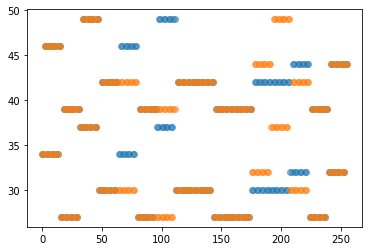

In [3]:
idx = 0
plt.scatter(np.arange(256), samples[idx, :], alpha=0.5)
plt.scatter(np.arange(256), descrambled_test_dataset[test_data_idx, :], alpha=0.5)
plt.show()